In [1]:
# !unzip "training.zip"

Archive:  training.zip
replace training.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
import pandas as pd
import numpy as np
train_data = pd.read_csv('training.csv')
                         
test_data = pd.read_csv('test.csv')

lookid_data = pd.read_csv('IdLookupTable.csv')

In [3]:
train_data.columns,len(train_data.columns)


(Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
        'right_eye_center_y', 'left_eye_inner_corner_x',
        'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
        'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
        'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
        'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
        'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
        'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
        'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
        'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
        'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
        'mouth_right_corner_y', 'mouth_center_top_lip_x',
        'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
        'mouth_center_bottom_lip_y', 'Image'],
       dtype='object'), 31)

In [4]:
test_data.columns

Index(['ImageId', 'Image'], dtype='object')

In [5]:
lookid_data.columns

Index(['RowId', 'ImageId', 'FeatureName', 'Location'], dtype='object')

In [6]:
train_data.isnull().any().value_counts()

True     28
False     3
dtype: int64

In [7]:
train_data.fillna(method = 'ffill',inplace = True)
train_data.isnull().any().value_counts()

False    31
dtype: int64

In [8]:
import random
import torch
import time
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [9]:
imag = []
for i in range(0,7049):
    img = train_data['Image'][i].split(' ')
    img = ['0' if x == '' else x for x in img]
    imag.append(img)

image_list = np.array(imag,dtype = 'float')
X_train = image_list.reshape(-1,1,96,96)



In [10]:
training = train_data.drop('Image',axis = 1)

y_train = []
for i in range(0,7049):
    y = training.iloc[i,:]

    y_train.append(y)
y_train = np.array(y_train,dtype = 'float')

In [11]:
class Dataset(Dataset):
    """User defined class to build a datset using Pytorch class Dataset."""
    
    def __init__(self, X_train,y_train, transform = None):
        self.X_train = X_train
        self.y_train = y_train
        self.transform = transform
        
    def __getitem__(self, index):
        image = self.X_train[index]
        keypoints = self.y_train[index]
        
        image = torch.from_numpy(np.asarray(image))
        keypoints = torch.from_numpy(np.asarray(keypoints))
        return image, keypoints

    def __len__(self):
        return len(self.X_train)

In [12]:
train_set = Dataset(X_train,y_train)
train_loader = DataLoader(train_set, batch_size=256)


In [13]:
a = next(iter(train_loader))
a[0].size(),a[1].size()

(torch.Size([256, 1, 96, 96]), torch.Size([256, 30]))

In [75]:
img = a[0][0]
points = a[1][0]

In [76]:
img = img.numpy().reshape(96,96)

points = points.numpy()

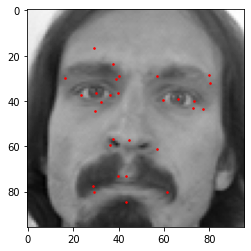

In [77]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image,cmap='gray')
    for i in range(29):
        plt.scatter(landmarks[i], landmarks[i+1], s=10, marker='.', c='r')
        i=i+1
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(img,
               points)
plt.show()


In [17]:
class FaceModel(nn.Module):
    
    def __init__(self):
        super(FaceModel, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(32))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64))
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2))
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(64,96, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(96))
        
        self.layer6 = nn.Sequential(
            nn.Conv2d(96, 96, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(2, 2))
        
        self.layer7 = nn.Sequential(
            nn.Conv2d(96,128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128))
        
        self.layer8 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2))
        
        self.layer9 = nn.Sequential(
            nn.Conv2d(128,256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256))
        
        self.layer10 = nn.Sequential(
            nn.Conv2d(256,256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2))
        
        self.layer11 = nn.Sequential(
            nn.Conv2d(256,512, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(512))
        

        self.fc = torch.nn.Sequential(torch.nn.Linear(4608,512),
                                          torch.nn.ReLU(inplace=True),
                                          nn.Dropout(p=0.1),
                                          torch.nn.Linear(512, 30))
        
    
    def forward(self, x):
        x = self.layer1(x)
       
        x = self.layer2(x)
       
        x = self.layer3(x)
        
        
        x = self.layer4(x)
        
        x = self.layer5(x)
        
        x = self.layer6(x)
       
        x = self.layer7(x)
       
        
        x = self.layer8(x)
        
        x = self.layer9(x)
      
        x = self.layer10(x)
       
        x = self.layer11(x)
  
       
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)

        return x

In [18]:
model = FaceModel().to(device,dtype=torch.double)
model

FaceModel(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [19]:
for idx ,sample in enumerate(train_loader):
    print(sample[0][0].shape,sample[1].shape)
    model(sample[0].to(device))
    break

torch.Size([1, 96, 96]) torch.Size([256, 30])


In [20]:
loss_fn = torch.nn.MSELoss()
optimizer =  optim.RMSprop(model.parameters(), lr=1e-3)
num_epochs = 200

In [21]:
def train(model, device, train_loader, optimizer,loss_fn, epoch, log_interval):
    model.train()
    train_loss = 0

    for batch_idx, sample in enumerate(train_loader):
        data,y = sample[0].to(device),sample[1].to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        l = loss_fn(y_pred,y)
        l.backward()
        optimizer.step()
        train_loss += l.item()

        if batch_idx % log_interval == 0:
            print('{} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                time.ctime(time.time()), epoch, batch_idx * len(data),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), l.item()))
    train_loss /= len(train_loader)
    print('Train set Average loss:', train_loss)
    return train_loss

In [29]:
PRINT_INTERVAL = 10
for epoch in range(0,100):
    train(model, device, train_loader, optimizer,loss_fn, epoch, PRINT_INTERVAL)

Tue Jul 14 13:42:28 2020 Train Epoch: 0 [0/7049 (0%)]	Loss: 33.396596
Tue Jul 14 13:42:33 2020 Train Epoch: 0 [2560/7049 (36%)]	Loss: 24.462098
Tue Jul 14 13:42:37 2020 Train Epoch: 0 [5120/7049 (71%)]	Loss: 43.977672
Train set Average loss: 35.94512770541027
Tue Jul 14 13:42:40 2020 Train Epoch: 1 [0/7049 (0%)]	Loss: 34.944917
Tue Jul 14 13:42:45 2020 Train Epoch: 1 [2560/7049 (36%)]	Loss: 16.467107
Tue Jul 14 13:42:49 2020 Train Epoch: 1 [5120/7049 (71%)]	Loss: 54.738038
Train set Average loss: 36.534374967758545
Tue Jul 14 13:42:53 2020 Train Epoch: 2 [0/7049 (0%)]	Loss: 36.388847
Tue Jul 14 13:42:57 2020 Train Epoch: 2 [2560/7049 (36%)]	Loss: 17.640987
Tue Jul 14 13:43:02 2020 Train Epoch: 2 [5120/7049 (71%)]	Loss: 64.293859
Train set Average loss: 38.24665577133451
Tue Jul 14 13:43:05 2020 Train Epoch: 3 [0/7049 (0%)]	Loss: 30.672143
Tue Jul 14 13:43:10 2020 Train Epoch: 3 [2560/7049 (36%)]	Loss: 43.261360
Tue Jul 14 13:43:14 2020 Train Epoch: 3 [5120/7049 (71%)]	Loss: 25.661480
T

In [30]:
timag = []
for i in range(0,1783):
    timg = test_data['Image'][i].split(' ')
    timg = ['0' if x == '' else x for x in timg]
    
    timag.append(timg)

In [31]:
timage_list = np.array(timag,dtype = 'float')
X_test = timage_list.reshape(-1,96,96,1)

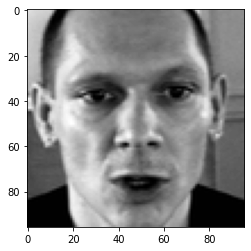

In [32]:
plt.imshow(X_test[2].reshape(96,96),cmap = 'gray')
plt.show()

In [33]:
X_test = torch.from_numpy(np.asarray(X_test))
test_loader = DataLoader(X_test, batch_size=256)

In [34]:
device

device(type='cuda', index=0)

In [36]:
q = []
for i ,sample in enumerate(test_loader):
    sample = sample.view(-1,1,96,96)
    q.append((model(sample.to(device)),sample))  
    break
    

In [65]:
points = q[0][0][1].cpu().detach().numpy()
image = q[0][1][1].cpu().detach().numpy()

In [66]:
image.shape, points.shape

((1, 96, 96), (30,))

In [67]:
image = image.reshape(96,96)
image.shape

(96, 96)

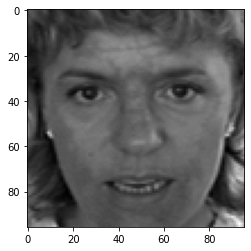

In [68]:
plt.imshow(image,cmap='gray')

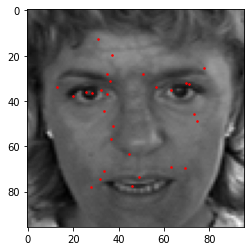

In [74]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image,cmap='gray')
    for i in range(29):
        plt.scatter(landmarks[i], landmarks[i+1], s=10, marker='.', c='r')
        i=i+1
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(image,
               points)
plt.show()